In [1]:
import torch
from VRP_Net_L import VRPNet_L
from matplotlib import pyplot as plt
import utils
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import LSE_net
import importlib
from DatasetGenerator import generate_dataset, torchFLPO_2_numpyFLPO
from viz import plot_UAV_FLPO, plot_UAV_FLPO_3D
from pathlib import Path
import GD
from Anneal import anneal

In [2]:
seed=0;
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
print("Running on: " , device)

Running on:  cuda


### Initialize an FLPO scenario

Run the below command if you encounter errors running the plotting block.

In [3]:
# !pip install nbformat --upgrade


num_drones = 100	num_facilities = 20	dim = 2
Data Created.


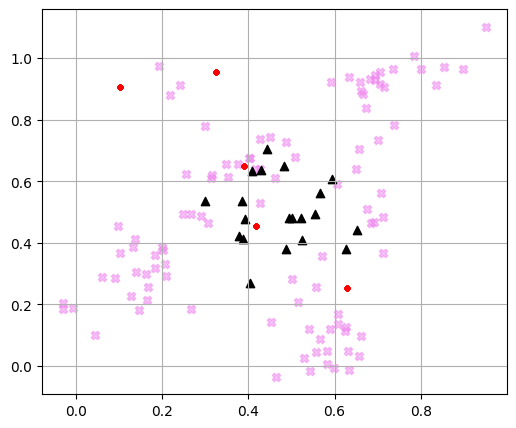

In [4]:
num_drones = 100
n_drone_clusters = 20
drone_cluster_split = np.random.uniform(0.0, 1.0, n_drone_clusters)
drone_cluster_split = drone_cluster_split / np.sum(drone_cluster_split)
num_facilities = 20
num_distinct_ends = 5
dim_ = 2
print(f"num_drones = {num_drones}\tnum_facilities = {num_facilities}\tdim = {dim_}")

START_locs, F_base, END_locs = generate_dataset(
    num_drones, n_drone_clusters, drone_cluster_split, num_facilities, dim_, device, drone_cluster_std_range=[0.02, 0.08], F_noise_std=0.1,num_distinct_ends=num_distinct_ends
)
np_flpo_filename = 'numpy_FLPO_data/numpy_FLPO_data'
torchFLPO_2_numpyFLPO(START_locs, END_locs, F_base, np_flpo_filename, scale=1.0)

plot_UAV_FLPO(START_locs, END_locs, F_base)
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Load the VRP NET Module

In [5]:
torch.cuda.empty_cache()
model_classes = {"VRPNet_L": VRPNet_L}
weights_address = (
    Path("Saved_models") /
    "VRPNet_L_lr1e-04_bs32_ep60000_samples1920000_cities50_inputdim2_"
    "workers0_hidden64_enc1_dec1_heads8_dropout0.30_"
    "train_PO_2025_05_17_22_43_32last_model.pth"
)
vrp_net = utils.load_model(
    weights_address, model_classes, weights_only=True, device=device
)
for param in vrp_net.parameters():
    param.requires_grad = False
print("VRP NET loaded on: ", vrp_net.device)
print(summary(vrp_net))

Model created.
VRP NET loaded on:  cuda
Layer (type:depth-idx)                                                 Param #
VRPNet_L                                                               --
├─LinearAttnEncoder: 1-1                                               2,048
│    └─ModuleList: 2-1                                                 --
│    │    └─MultiheadAttention: 3-1                                    (66,048)
│    │    └─MultiheadAttention: 3-2                                    (66,048)
│    │    └─MultiheadAttention: 3-3                                    (66,048)
│    │    └─MultiheadAttention: 3-4                                    (66,048)
│    │    └─MultiheadAttention: 3-5                                    (66,048)
│    │    └─MultiheadAttention: 3-6                                    (66,048)
│    └─ModuleList: 2-2                                                 --
│    │    └─MultiheadAttention: 3-7                                    (66,048)
│    │    └─MultiheadA

### Load the LSE net module

In [6]:
importlib.reload(LSE_net)
lse_data = torch.load('logSumExp_models/lse_2025_5_19__15_47_58.pth', weights_only=False)
n_inputs = lse_data['n_inputs']
n_outputs = lse_data['n_outputs']
layers = lse_data['layers']
weights = lse_data['model_state_dict']
io_scale = lse_data['io_scale']
D_max_range = lse_data['D_max_range']
lse_net = LSE_net.dnn(n_inputs, n_outputs, layers)
lse_net.to(device)
lse_net.load_state_dict(weights)
lse_net.eval()
for p in lse_net.parameters():
    p.requires_grad = False
print(f'D_max_scale: {D_max_range}\nn_inputs: {n_inputs}\nn_outputs: {n_outputs}\nlayers: {layers}\nio_scale: {io_scale}\nLSE_net:\n{summary(lse_net)}')

D_max_scale: 5.0
n_inputs: 3
n_outputs: 1
layers: [20, 20, 10]
io_scale: 1
LSE_net:
Layer (type:depth-idx)                   Param #
dnn                                      --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       (80)
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       (420)
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       (210)
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       (11)
Total params: 721
Trainable params: 0
Non-trainable params: 721


### Optimization loop for a single beta
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

In [7]:
# optim_iters = 200
# optim_step = 0.1
# b_min = 1e-3
# beta = 1e-3
# tol = 1e-3

# print(D_max_range)
# F_base, FreeEnergy, G = GD.Adam_at_beta(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters,
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

# F_base, FreeEnergy, G = GD.GD_at_beta1(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

# F_base, FreeEnergy, G = GD.GD_at_beta0(
#     F_base, START_locs, END_locs, vrp_net, lse_net, optim_iters, 
#     optim_step, b_min, beta, D_max_range=D_max_range, tol=tol, allowPrint=True)

In [8]:
# plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))
# plot_UAV_FLPO_3D(START_locs, END_locs, F_base)


### Annealing loop implementation
Warning: Use $\beta >= 1e-3$, as the free energy approximation is poor for $\beta < 5e-4$ with torch.float32 datatype.

In [ ]:
beta_min = 1e-3
beta_max = 1e5
beta_grow = 3
optim_iters = 10
optim_step = 0.01 # 0.1 for gd0, use < 0.01 for the other two optimizers
optim_name = 'adam'
tol = 1e-2

F_base, b_arr, F_arr = anneal(
        F_base, START_locs,END_locs, vrp_net, lse_net, optim_iters, optim_step, 
        beta_min, beta_max, beta_grow, D_max_range=D_max_range, tol=tol,
        optimizer_name=optim_name, allowPrint=True
    )


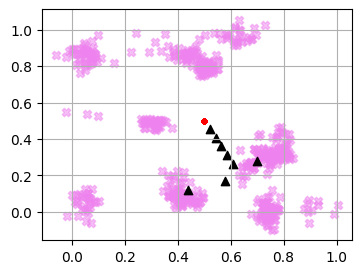

In [27]:
plot_UAV_FLPO(START_locs, END_locs, F_base, (4,3))
plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

### Plot free energy during annealing implementation

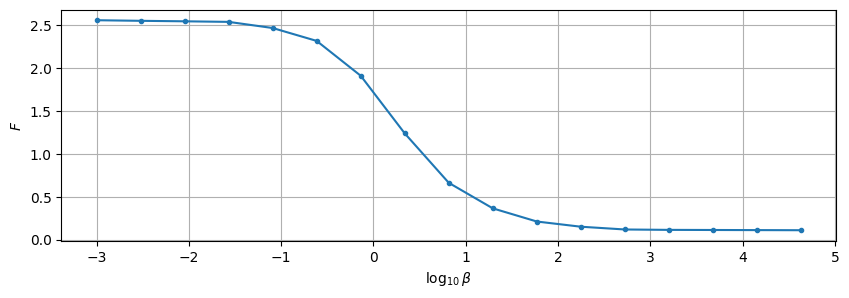

In [28]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr)/np.log(10), F_arr, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()

### Compare with original FLPO solution

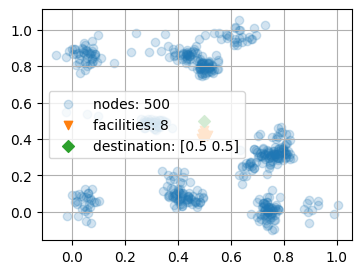

In [29]:
import classFLPO as cf
importlib.reload(cf)

flpo_filename = 'numpy_FLPO_data/numpy_FLPO_data'
flpo = cf.FLPO(flpo_filename, plotFLPO=True, disType='sqeuclidean', selfHop=True)

In [30]:
Y0 = flpo.facilityLocations
Y0

array([[0.49882749, 0.42972246],
       [0.4941974 , 0.43253422],
       [0.50038958, 0.44777051],
       [0.51102668, 0.41774613],
       [0.49755415, 0.41752037],
       [0.51315767, 0.42047659],
       [0.48990202, 0.42614391],
       [0.48860595, 0.40618882]])

In [31]:
init_guess = Y0.flatten()
init_guess

array([0.49882749, 0.42972246, 0.4941974 , 0.43253422, 0.50038958,
       0.44777051, 0.51102668, 0.41774613, 0.49755415, 0.41752037,
       0.51315767, 0.42047659, 0.48990202, 0.42614391, 0.48860595,
       0.40618882])

In [32]:
# flpo.bounds

In [33]:
cost, params, time = flpo.optimize_D(init_guess, beta=1e3, method='trust-constr', method_options={'verbose':1})

`gtol` termination condition is satisfied.
Number of iterations: 67, function evaluations: 1037, CG iterations: 245, optimality: 5.58e-09, constraint violation: 0.00e+00, execution time: 0.41 s.


In [34]:
cost

0.07150209376018427

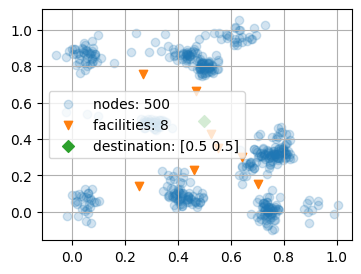

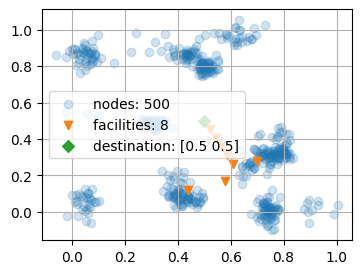

In [35]:
flpo.facilityLocations = params.reshape(-1,2)
flpo.plotFLPO()
ext_facilities = F_base.to(torch.float64).squeeze().detach().numpy()
flpo.facilityLocations = ext_facilities
flpo.plotFLPO()

In [36]:
beta_o = beta_min
params_o = Y0.flatten()
b_arr_o = []
F_arr_o = []

while beta_o <= beta_max:
    cost_o, params_o, time = flpo.optimize_D(params_o, beta=beta_o, method='trust-constr', method_options={'verbose':0})
    b_arr_o.append(beta_o)
    F_arr_o.append(cost_o)

    params_o = params_o + 0.01*np.random.uniform(-1,1,params_o.shape)
    beta_o = beta_grow * beta_o

    print(
        f"beta: {beta_o:.4e}\tFreeE: {cost_o:.4f}"
    )

/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



beta: 3.0000e-03	FreeE: -16768.8752
beta: 9.0000e-03	FreeE: -5589.4994
beta: 2.7000e-02	FreeE: -1863.0408
beta: 8.1000e-02	FreeE: -620.8879
beta: 2.4300e-01	FreeE: -206.8369
beta: 7.2900e-01	FreeE: -68.8199
beta: 2.1870e+00	FreeE: -22.8143
beta: 6.5610e+00	FreeE: -7.4791
beta: 1.9683e+01	FreeE: -2.3673
beta: 5.9049e+01	FreeE: -0.6634
beta: 1.7715e+02	FreeE: -0.1008
beta: 5.3144e+02	FreeE: 0.0483
beta: 1.5943e+03	FreeE: 0.0694
beta: 4.7830e+03	FreeE: 0.0739
beta: 1.4349e+04	FreeE: 0.0754
beta: 4.3047e+04	FreeE: 0.0759
beta: 1.2914e+05	FreeE: 0.0741


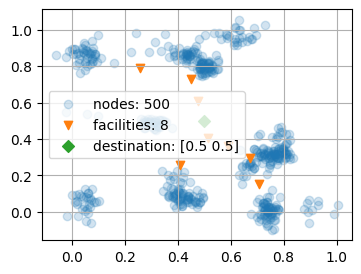

In [37]:
flpo.facilityLocations = params_o.reshape(-1,2)
flpo.plotFLPO()

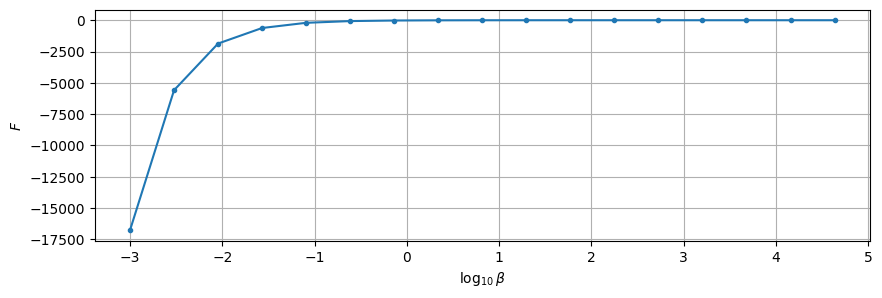

In [38]:
# plot free energy evolution
plt.figure(figsize=(10,3))
plt.plot(np.log(b_arr_o)/np.log(10), F_arr_o, marker='.')
plt.ylabel(rf'$F$')
plt.xlabel(rf'$\log_{{10}}\beta$')
plt.grid()
plt.show()